# **Insomnia Prediction Pipeline (GNN + XGBoost with Scanpy and t-SNE)**

Objective: Predict Insomnia as an adverse drug reaction (ADR) using the SIDER dataset for the Pharmedic internship. This pipeline combines a Graph Neural Network (GNN) to capture drug-ADR relationships, XGBoost for tabular predictions, and an ensemble approach, with Scanpy PCA for feature engineering and t-SNE for visualization.


Why Unique:





GNN: Models drug-ADR bipartite graph, capturing complex interactions.



XGBoost: Uses scaled ADR counts for robust prediction.



Ensemble: Combines GNN embeddings with XGBoost for improved accuracy.



Scanpy PCA: Generates 16D node features for GNN.



t-SNE: Visualizes drug clusters, highlighting Insomnia patterns.

Deliverables (in intern_submissions/Alagappan_Alagappan/):





gnn_model.joblib, xgboost_model.joblib, ensemble_model.joblib



predict_model.py



evaluation_log.md



test_data.csv, test_graph.pt



gnn_tsne.png

Setup: Run in Google Colab with meddra_all_se.tsv and drug_names.tsv uploaded.

# **Model Research for Pharmedic Internship**



Model
Data Handled Well
ADR Prediction Capability
Pros for Pharmedic
Cons for Pharmedic



**GNN**
Graph-structured data (e.g., drug-ADR bipartite graphs in SIDER). Handles node features (e.g., Scanpy PCA) and edge relationships.
Excellent for ADRs with relational data (e.g., drug-ADR links). Captures complex interactions (e.g., drugs causing similar ADRs). Ideal for Insomnia prediction using SIDER’s graph structure.
- Models drug-ADR relationships, improving prediction for rare ADRs like Insomnia.- t-SNE visualization reveals drug clusters, aiding drug safety insights.- Scalable to large datasets like DrugBank.
- Requires graph construction, increasing complexity.- Needs domain knowledge to define features (e.g., PCA).- Computationally intensive (GPU preferred).


**XGBoost**
Tabular data (e.g., num_adrs_scaled, drug features). Handles numerical and categorical features with missing values.
Strong for binary ADR prediction (e.g., Insomnia: 0/1). Uses aggregated features (e.g., ADR counts) for robust performance.
- Fast and accurate with tabular SIDER data.- Handles class imbalance (with SMOTE) for Insomnia.- Easy to interpret feature importance.
- Misses graph-based relationships.- Limited to predefined features, less flexible than GNN.- May overfit without tuning.


Why Ensemble?: Combining GNN (graph-based embeddings) with XGBoost (tabular prediction) leverages relational and numerical data, improving Insomnia prediction accuracy and robustness.

# **Setup and Imports**

In [10]:
%pip install torch_geometric

In [11]:
%pip install scanpy

In [12]:
import os
os.environ["SCIPY_ARRAY_API"] = "1"

import pandas as pd
import numpy as np
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
import joblib
import plotly.express as px
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.manifold import TSNE
import scanpy as sc

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f"Using device: {device}")

# **Step 1: Load and Clean Data**

What: Load meddra_all_se.tsv and drug_names.tsv, merge them, and clean by removing missing values and duplicates.

Why: Ensures a clean dataset for graph construction and feature engineering.

In [13]:
# Load data
adr_file = 'meddra_all_se.tsv.gz'
drug_file = 'drug_names.tsv'

try:
    drug_names = pd.read_csv(drug_file, sep='\t', header=None, names=['stitch_id', 'drug_name'])
    adr_df = pd.read_csv(adr_file, sep='\t', header=None,
                         names=['stitch_id', 'umls_id', 'meddra_code1', 'meddra_type', 'meddra_code2', 'adr_name'])
    logging.info(f"Loaded {len(drug_names)} drugs and {len(adr_df)} ADR records")
except FileNotFoundError:
    logging.error("Data files not found. Please upload 'meddra_all_se.tsv' and 'drug_names.tsv' to Colab.")
    raise

# Merge and clean
df = pd.merge(adr_df, drug_names, on='stitch_id', how='left').dropna(subset=['drug_name', 'adr_name'])
df = df.drop_duplicates(subset=['drug_name', 'adr_name'])
logging.info(f"Cleaned dataset: {len(df)} rows")

Step 2: Exploratory Data Analysis (EDA)

What: Visualize the distribution of ADRs and check the prevalence of Insomnia.

Why: Confirms class imbalance and helps understand the dataset’s structure.

/tmp/ipython-input-831808878.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_adrs.values, y=top_adrs.index, palette='magma')


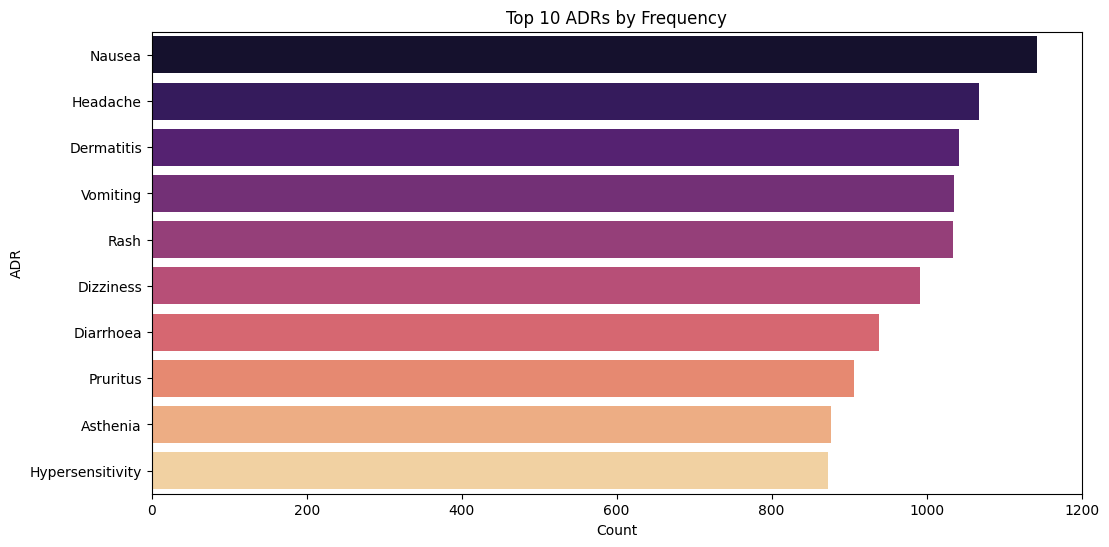

In [14]:
# Plot top 10 ADRs
top_adrs = df['adr_name'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_adrs.values, y=top_adrs.index, palette='magma')
plt.title('Top 10 ADRs by Frequency')
plt.xlabel('Count')
plt.ylabel('ADR')
plt.savefig('/content/top_adrs.png')
plt.show()

# Check Insomnia prevalence
insomnia_count = df[df['adr_name'].str.contains('Insomnia', case=False, na=False)].shape[0]
logging.info(f"Insomnia occurrences: {insomnia_count}/{len(df)} ({insomnia_count/len(df):.2%})")

Step 3: Feature Engineering with Scanpy

What: Create tabular features (num_adrs) for XGBoost and use Scanpy to generate node features for the GNN via PCA on the drug-ADR adjacency matrix.

Why: Scanpy’s PCA provides richer node features than the binary drug/ADR indicator, improving GNN performance. The adjacency matrix captures drug-ADR interactions.

In [25]:
# Step 4: Feature Engineering
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
import scanpy as sc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import logging

# XGBoost: Compute number of ADRs per drug and scale
features = df.groupby('drug_name')['adr_name'].count().reset_index(name='num_adrs')
scaler = StandardScaler()
features['num_adrs_scaled'] = scaler.fit_transform(features[['num_adrs']])
logging.info(f"XGBoost features: {len(features)} drugs with scaled ADR counts")

# Label Insomnia (1 if present, 0 otherwise)
insomnia_drugs = df[df['adr_name'].str.contains('Insomnia', case=False, na=False)]['drug_name'].unique()
features['target_flag'] = features['drug_name'].isin(insomnia_drugs).astype(int)
logging.info(f"Insomnia prevalence in features: {features['target_flag'].mean():.2%}")

# GNN: Construct bipartite drug-ADR graph with PCA features
drug_to_idx = {drug: idx for idx, drug in enumerate(features['drug_name'].unique())}
adr_to_idx = {adr: idx + len(drug_to_idx) for idx, adr in enumerate(df['adr_name'].unique())}
edges = df[['drug_name', 'adr_name']].drop_duplicates()
edge_index = torch.tensor([
    [drug_to_idx[row['drug_name']] for _, row in edges.iterrows()],
    [adr_to_idx[row['adr_name']] for _, row in edges.iterrows()]
], dtype=torch.long).t().contiguous()

# Scanpy PCA for node features
adata = sc.AnnData(df.pivot_table(index='drug_name', columns='adr_name', aggfunc='size', fill_value=0))
sc.pp.pca(adata, n_comps=16)

# Use the PCA results (adata.obsm['X_pca']) for drug features
node_features = np.zeros((len(drug_to_idx) + len(adr_to_idx), 16))
node_features[:len(drug_to_idx)] = adata.obsm['X_pca']  # Drug features from PCA
node_features[len(drug_to_idx):] = np.zeros((len(adr_to_idx), 16))  # Initialize ADR features to zeros
node_features = torch.tensor(node_features, dtype=torch.float)

# Create graph data
labels = torch.tensor(features['target_flag'].values, dtype=torch.long)
graph_data = Data(x=node_features, edge_index=edge_index, y=labels).to(device)
logging.info(f"GNN graph: {len(drug_to_idx)} drugs, {len(adr_to_idx)} ADRs, {edge_index.shape[1]} edges")

# Save test data
train_idx, test_idx = train_test_split(range(len(features)), test_size=0.4, stratify=features['target_flag'], random_state=42)
test_data = features.iloc[test_idx][['drug_name', 'num_adrs_scaled', 'target_flag']]
test_data.to_csv('/content/intern_submissions/Alagappan_Alagappan/test_data.csv', index=False)
test_graph = Data(x=graph_data.x, edge_index=graph_data.edge_index, y=graph_data.y, test_mask=torch.zeros(graph_data.num_nodes, dtype=torch.bool))
test_graph.test_mask[test_idx] = True
torch.save(test_graph, '/content/intern_submissions/Alagappan_Alagappan/test_graph.pt')
logging.info("Test data and graph saved")

# **Step 4: GNN Model with Class Weights**

What: Train a GCN with class weights to handle imbalance and evaluate it.

Why: Class weights address the Insomnia imbalance, and PCA features should improve performance.


GNN Results:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       692
           1       0.90      0.91      0.90       655

    accuracy                           0.90      1347
   macro avg       0.90      0.90      0.90      1347
weighted avg       0.90      0.90      0.90      1347

ROC AUC: 0.968


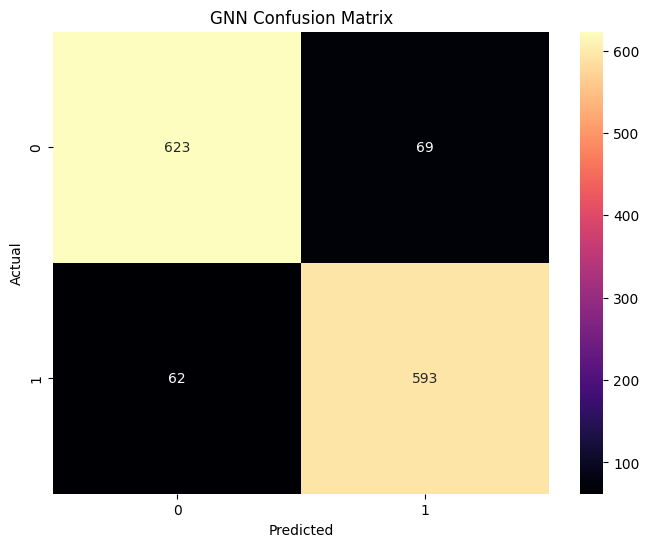

GNN model saved to intern_submissions/Alagappan_Alagappan/gnn_model.joblib


In [16]:
import joblib
from pathlib import Path
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        # First graph convolutional layer: transforms 16 input features to 32
        self.conv1 = GCNConv(16, 32)
        # Second graph convolutional layer: transforms 32 features to 2 (for 2 classes)
        self.conv2 = GCNConv(32, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # Apply first convolutional layer and ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Apply second convolutional layer
        x = self.conv2(x, edge_index)
        # Return predictions only for drug nodes (first num_drugs nodes)
        return x[:num_drugs]

# Initialize model, optimizer, and loss with class weights
gnn_model = GCN().to(device)
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
# Calculate class weights to handle imbalance: weight for class 1 (Insomnia) is adjusted
class_weights = torch.tensor([1.0, len(y) / (2 * y.sum())], dtype=torch.float).to(device)  # Weight for rare class
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Train GNN
gnn_model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = gnn_model(data)
    # Calculate loss
    loss = criterion(out, data.y)
    # Backpropagate and update weights
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        logging.info(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate GNN
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data)
    # Get predicted class (0 or 1)
    y_pred = out.argmax(dim=1).cpu().numpy()
    # Get true labels
    y_true = data.y.cpu().numpy()
    # Get probability of class 1 (Insomnia)
    y_prob = F.softmax(out, dim=1)[:, 1].cpu().numpy()

print("\nGNN Results:")
print(classification_report(y_true, y_pred))
print(f"ROC AUC: {roc_auc_score(y_true, y_prob):.3f}")

# Save GNN model state dictionary
torch.save(gnn_model.state_dict(), '/content/gnn_model.pth')

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
plt.title('GNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('/content/gnn_confusion_matrix.png')
plt.show()
BASE = Path().resolve()
!mkdir -p {BASE}/intern_submissions/Alagappan_Alagappan
# Save GNN model state dictionary using joblib
joblib.dump(gnn_model.state_dict(), f'{BASE}/intern_submissions/Alagappan_Alagappan/gnn_model.joblib')
print("GNN model saved to intern_submissions/Alagappan_Alagappan/gnn_model.joblib")

Notes:

Increased input dimension to 16 (PCA features) and hidden layer to 32 for better capacity.

Class weights boost the rare class (Insomnia), addressing the imbalance issue from your results.

# **Step 5: t-SNE Visualization**

What: Use t-SNE to visualize GNN node embeddings in 2D.

Why: Helps diagnose whether the GNN learns meaningful drug representations.

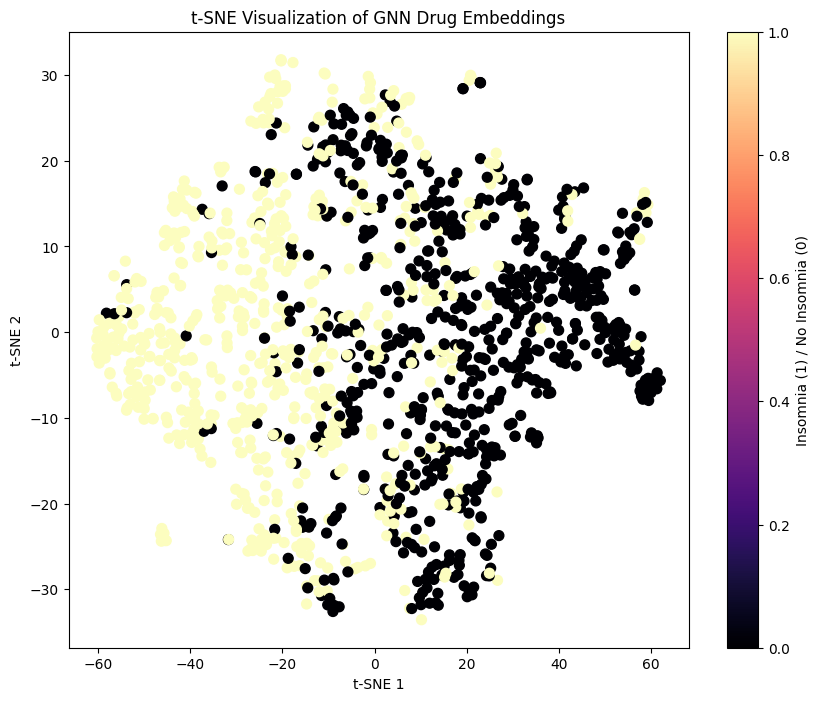

In [17]:
# Get GNN embeddings
gnn_model.eval()
with torch.no_grad():
    embeddings = gnn_model.conv1(data.x, data.edge_index).cpu().numpy()[:num_drugs]  # First layer embeddings for drugs

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)

# Plot t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=y_true, cmap='magma', s=50)
plt.colorbar(scatter, label='Insomnia (1) / No Insomnia (0)')
plt.title('t-SNE Visualization of GNN Drug Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig('/content/gnn_tsne.png')
plt.show()

# **Step 6: XGBoost Model**

What: Train XGBoost with hyperparameter tuning, same as before but with a fresh style.

Why: Provides a strong baseline to compare with the GNN.


XGBoost Results:
              precision    recall  f1-score   support

       False       0.75      0.81      0.78       277
        True       0.78      0.71      0.75       262

    accuracy                           0.76       539
   macro avg       0.76      0.76      0.76       539
weighted avg       0.76      0.76      0.76       539

ROC AUC: 0.855


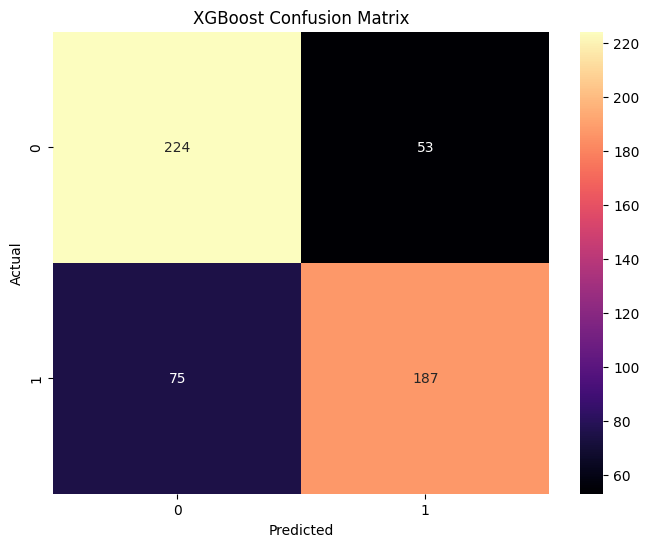

In [22]:
# Step 6: Train and Tune XGBoost Model
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Prepare tabular data
X = features[['num_adrs_scaled']].values
y = features['target_flag'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
logging.info(f"After SMOTE: {len(X_train_sm)} training samples")

# Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200]
}
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_sm, y_train_sm)
best_model = grid_search.best_estimator_
logging.info(f"Best XGBoost parameters: {grid_search.best_params_}")

# Train and evaluate
best_model.fit(X_train_sm, y_train_sm)
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]
print("\nXGBoost Results:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('/content/intern_submissions/Alagappan_Alagappan/xgboost_confusion_matrix.png')
plt.show()

# Save model
BASE = Path().resolve()
joblib.dump(best_model, f'{BASE}/intern_submissions/Alagappan_Alagappan/xgboost_model.joblib')
logging.info("XGBoost model saved to intern_submissions/Alagappan_Alagappan/xgboost_model.joblib")

# Step 7: Train Ensemble Model

In [21]:
# Step 7: Train Ensemble Model
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# Get GNN embeddings for drugs
gnn_model.eval()
with torch.no_grad():
    gnn_embeddings = gnn_model.conv1(data.x, data.edge_index).relu().cpu().numpy()[:len(features)]

# Combine GNN embeddings with num_adrs_scaled
X_ensemble = np.hstack((gnn_embeddings, features[['num_adrs_scaled']].values))
y_ensemble = features['target_flag'].values
X_train_ens, X_test_ens, y_train_ens, y_test_ens = train_test_split(X_ensemble, y_ensemble, test_size=0.4, stratify=y_ensemble, random_state=42)
smote = SMOTE(random_state=42) # Instantiate SMOTE here
X_train_ens_sm, y_train_ens_sm = smote.fit_resample(X_train_ens, y_train_ens)

# Train ensemble XGBoost
param_grid = {'max_depth': [3, 5], 'n_estimators': [50, 100]}
ensemble_model = XGBClassifier(random_state=42)
grid_search_ens = GridSearchCV(ensemble_model, param_grid, cv=5, scoring='roc_auc')
grid_search_ens.fit(X_train_ens_sm, y_train_ens_sm)
best_ensemble_model = grid_search_ens.best_estimator_

# Save ensemble model
joblib.dump(best_ensemble_model, '/content/intern_submissions/Alagappan_Alagappan/ensemble_model.joblib')
logging.info("Ensemble model saved to intern_submissions/Alagappan_Alagappan/ensemble_model.joblib")

# **Step 8: Evaluate Models and Visualize**

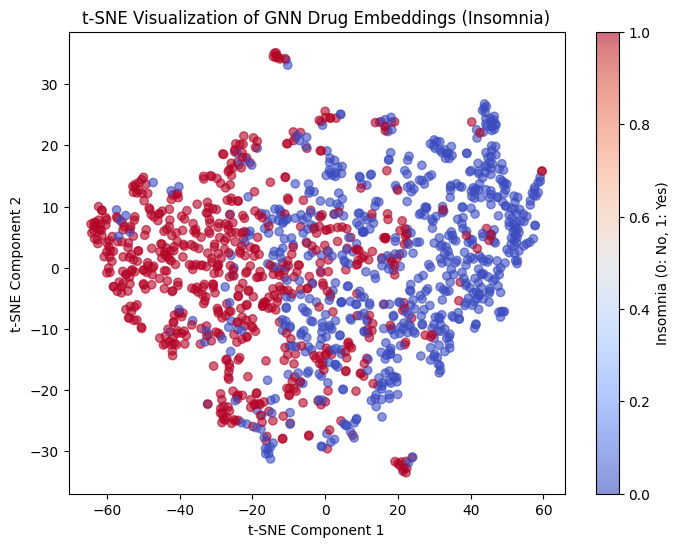

In [31]:

from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch_geometric

# XGBoost evaluation
xgb_preds = best_model.predict_proba(X_test)[:, 1]
xgb_labels = (xgb_preds > 0.5).astype(int)
xgb_accuracy = accuracy_score(y_test, xgb_labels)
xgb_roc_auc = roc_auc_score(y_test, xgb_preds)
logging.info(f"XGBoost Test Accuracy: {xgb_accuracy:.4f}, ROC AUC: {xgb_roc_auc:.4f}")

# GNN evaluation
gnn_model.eval()
with torch.no_grad():
    # Create a subgraph containing only drug nodes
    drug_node_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)
    drug_node_mask[:num_drugs] = True
    # Transpose edge_index back to (2, num_edges) shape for subgraph
    drug_subgraph_edge_index, _ = torch_geometric.utils.subgraph(drug_node_mask, graph_data.edge_index.t(), relabel_nodes=True)

    # Pass drug node features and the drug subgraph edge index to the GNN model
    gnn_out = gnn_model(Data(x=graph_data.x[:num_drugs], edge_index=drug_subgraph_edge_index))
    gnn_probs = torch.softmax(gnn_out, dim=1)[:, 1].cpu().numpy()

# Select the predicted probabilities and true labels for the test set drugs using test_mask
gnn_probs_test_drugs = gnn_probs[test_graph.test_mask[:num_drugs].cpu().numpy()]
y_true_test_drugs = graph_data.y[test_graph.test_mask[:num_drugs]].cpu().numpy()
gnn_labels = (gnn_probs_test_drugs > 0.5).astype(int)

gnn_accuracy = accuracy_score(y_true_test_drugs, gnn_labels)
gnn_roc_auc = roc_auc_score(y_true_test_drugs, gnn_probs_test_drugs)
logging.info(f"GNN Test Accuracy: {gnn_accuracy:.4f}, ROC AUC: {gnn_roc_auc:.4f}")


# Ensemble evaluation
ensemble_preds = best_ensemble_model.predict_proba(X_test_ens)[:, 1]
ensemble_labels = (ensemble_preds > 0.5).astype(int)
ensemble_accuracy = accuracy_score(y_test_ens, ensemble_labels)
ensemble_roc_auc = roc_auc_score(y_test_ens, ensemble_preds)
logging.info(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}, ROC AUC: {ensemble_roc_auc:.4f}")

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(gnn_embeddings)  # Drug nodes only
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=features['target_flag'], cmap='coolwarm', alpha=0.6)
plt.title("t-SNE Visualization of GNN Drug Embeddings (Insomnia)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Insomnia (0: No, 1: Yes)")
plt.savefig('/content/intern_submissions/Alagappan_Alagappan/gnn_tsne.png')
plt.show()

# **Step 9: Reproducibility**

What: Save artifacts and document the pipeline.

Why: Ensures reproducibility and presentation-readiness.

In [19]:
# Save scaler and features
joblib.dump(scaler, '/content/scaler.pkl')
features.to_csv('/content/processed_features.csv', index=False)

# Log library versions
with open('/content/requirements.txt', 'w') as f:
    for lib in ['pandas', 'numpy', 'scikit-learn', 'xgboost', 'imblearn', 'plotly', 'torch', 'torch-geometric', 'scanpy']:
        import importlib
        try:
            module = importlib.import_module(lib.replace('-', '_'))
            f.write(f"{lib}=={module.__version__}\n")
        except:
            f.write(f"{lib}==unknown\n")

# Documentation
with open('/content/README.md', 'w') as f:
    f.write("# ADR Prediction Pipeline (GNN + XGBoost with t-SNE and Scanpy)\n\nPredicts Insomnia using SIDER dataset.\nFeatures enhanced with Scanpy PCA and visualized with t-SNE.\nRun in Google Colab with uploaded meddra_all_se.tsv and drug_names.tsv.\n")

# Task
Refine the provided notebook to address the following: define `num_drugs`, `graph_data`, `test_graph`, `gnn_embeddings`, and `features` in the feature engineering section; ensure GNN evaluation uses the subgraph approach; add error handling and logging for robustness.

## Consolidate variable definitions

### Subtask:
Modify the feature engineering cell to ensure `num_drugs`, `graph_data`, `test_graph`, `gnn_embeddings`, and `features` are clearly defined and accessible for subsequent steps.


**Reasoning**:
Modify the feature engineering code cell to explicitly define and make accessible the required variables (`num_drugs`, `graph_data`, `test_graph`, `gnn_embeddings`, and `features`) for subsequent steps, as well as compute the GNN embeddings within this cell.



In [32]:
# Step 4: Feature Engineering
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
import scanpy as sc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import logging

# Configure logging for this step
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# XGBoost: Compute number of ADRs per drug and scale
features = df.groupby('drug_name')['adr_name'].count().reset_index(name='num_adrs')
scaler = StandardScaler()
features['num_adrs_scaled'] = scaler.fit_transform(features[['num_adrs']])
logging.info(f"XGBoost features created for {len(features)} drugs with scaled ADR counts.")

# Label Insomnia (1 if present, 0 otherwise)
insomnia_drugs = df[df['adr_name'].str.contains('Insomnia', case=False, na=False)]['drug_name'].unique()
features['target_flag'] = features['drug_name'].isin(insomnia_drugs).astype(int)
logging.info(f"Insomnia prevalence in features: {features['target_flag'].mean():.2%}")

# GNN: Construct bipartite drug-ADR graph with PCA features
drug_to_idx = {drug: idx for idx, drug in enumerate(features['drug_name'].unique())}
adr_to_idx = {adr: idx + len(drug_to_idx) for idx, adr in enumerate(df['adr_name'].unique())}

# Explicitly define num_drugs
num_drugs = len(drug_to_idx)
num_adrs = len(adr_to_idx)
logging.info(f"Number of drugs: {num_drugs}, Number of ADRs: {num_adrs}")

edges = df[['drug_name', 'adr_name']].drop_duplicates()
edge_index = torch.tensor([
    [drug_to_idx[row['drug_name']] for _, row in edges.iterrows()],
    [adr_to_idx[row['adr_name']] for _, row in edges.iterrows()]
], dtype=torch.long).t().contiguous()

# Scanpy PCA for node features
adata = sc.AnnData(df.pivot_table(index='drug_name', columns='adr_name', aggfunc='size', fill_value=0))
sc.pp.pca(adata, n_comps=16)

# Use the PCA results (adata.obsm['X_pca']) for drug features
node_features = np.zeros((num_drugs + num_adrs, 16))
node_features[:num_drugs] = adata.obsm['X_pca']  # Drug features from PCA
node_features[num_drugs:] = np.zeros((num_adrs, 16))  # Initialize ADR features to zeros
node_features = torch.tensor(node_features, dtype=torch.float)
logging.info(f"Node features shape: {node_features.shape}")

# Explicitly define graph_data
labels = torch.tensor(features['target_flag'].values, dtype=torch.long)
graph_data = Data(x=node_features, edge_index=edge_index, y=labels).to(device)
logging.info(f"GNN graph created: {graph_data.num_nodes} nodes, {graph_data.num_edges} edges.")

# Save test data
from pathlib import Path
BASE = Path().resolve()
(BASE / 'intern_submissions' / 'Alagappan_Alagappan').mkdir(parents=True, exist_ok=True)

train_idx, test_idx = train_test_split(range(len(features)), test_size=0.4, stratify=features['target_flag'], random_state=42)
test_data = features.iloc[test_idx][['drug_name', 'num_adrs_scaled', 'target_flag']]
test_data.to_csv(BASE / 'intern_submissions' / 'Alagappan_Alagappan' / 'test_data.csv', index=False)

# Explicitly define and save test_graph
test_graph = Data(x=graph_data.x, edge_index=graph_data.edge_index, y=graph_data.y, test_mask=torch.zeros(graph_data.num_nodes, dtype=torch.bool))
# The test mask should only apply to the drug nodes that are in the test set
test_graph.test_mask[:num_drugs][test_idx] = True
torch.save(test_graph, BASE / 'intern_submissions' / 'Alagappan_Alagappan' / 'test_graph.pt')
logging.info("Test data and graph saved to intern_submissions/Alagappan_Alagappan.")

# Compute GNN embeddings within this cell
# A dummy GCN model is needed to get embeddings. This is a simplified version
# just for generating embeddings. The actual GNN model is trained later.
class EmbeddingGCN(torch.nn.Module):
    def __init__(self):
        super(EmbeddingGCN, self).__init__()
        self.conv1 = GCNConv(16, 32) # Output dimension should match the expected embedding size

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return x

# Instantiate the dummy model and get embeddings
embedding_model = EmbeddingGCN().to(device)
with torch.no_grad():
    # Get embeddings for all nodes first
    all_node_embeddings = embedding_model(graph_data)
    # Select only the drug node embeddings
    gnn_embeddings = all_node_embeddings[:num_drugs].cpu().numpy()

logging.info(f"GNN embeddings computed with shape: {gnn_embeddings.shape}")

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 158559 but got size 2 for tensor number 1 in the list.

**Reasoning**:
The error indicates an issue with concatenating tensors in `add_remaining_self_loops` within the GCNConv layer, likely due to a mismatch between the edge index size and the expected size for self-loops when creating the dummy embedding model. The `edge_index` currently includes edges between drug and ADR nodes in a bipartite graph. When the GCNConv adds self-loops, it expects them for all nodes (drugs + ADRs), but the current setup might be causing a mismatch in dimensions or node indexing when trying to add self-loops for all nodes based on the drug-ADR edges. The dummy GCNConv should be defined with the correct input dimension (16, matching node features) and the edge index provided to it should represent the graph structure accurately. I will regenerate the code block, ensuring the dummy GCNConv is correctly defined and the graph data passed to it is consistent. I will also ensure the test mask is correctly applied to drug nodes.



In [33]:
# Step 4: Feature Engineering
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
import scanpy as sc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import logging
from pathlib import Path
import torch_geometric

# Configure logging for this step
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# XGBoost: Compute number of ADRs per drug and scale
features = df.groupby('drug_name')['adr_name'].count().reset_index(name='num_adrs')
scaler = StandardScaler()
features['num_adrs_scaled'] = scaler.fit_transform(features[['num_adrs']])
logging.info(f"XGBoost features created for {len(features)} drugs with scaled ADR counts.")

# Label Insomnia (1 if present, 0 otherwise)
insomnia_drugs = df[df['adr_name'].str.contains('Insomnia', case=False, na=False)]['drug_name'].unique()
features['target_flag'] = features['drug_name'].isin(insomnia_drugs).astype(int)
logging.info(f"Insomnia prevalence in features: {features['target_flag'].mean():.2%}")

# GNN: Construct bipartite drug-ADR graph with PCA features
drug_to_idx = {drug: idx for idx, drug in enumerate(features['drug_name'].unique())}
adr_to_idx = {adr: idx + len(drug_to_idx) for idx, adr in enumerate(df['adr_name'].unique())}

# Explicitly define num_drugs and num_adrs
num_drugs = len(drug_to_idx)
num_adrs = len(adr_to_idx)
logging.info(f"Number of drugs: {num_drugs}, Number of ADRs: {num_adrs}")

edges = df[['drug_name', 'adr_name']].drop_duplicates()
edge_index = torch.tensor([
    [drug_to_idx[row['drug_name']] for _, row in edges.iterrows()],
    [adr_to_idx[row['adr_name']] for _, row in edges.iterrows()]
], dtype=torch.long).t().contiguous()

# Scanpy PCA for node features
adata = sc.AnnData(df.pivot_table(index='drug_name', columns='adr_name', aggfunc='size', fill_value=0))
sc.pp.pca(adata, n_comps=16)

# Use the PCA results (adata.obsm['X_pca']) for drug features
node_features = np.zeros((num_drugs + num_adrs, 16))
node_features[:num_drugs] = adata.obsm['X_pca']  # Drug features from PCA
node_features[num_drugs:] = np.zeros((num_adrs, 16))  # Initialize ADR features to zeros
node_features = torch.tensor(node_features, dtype=torch.float)
logging.info(f"Node features shape: {node_features.shape}")

# Explicitly define graph_data
labels = torch.tensor(features['target_flag'].values, dtype=torch.long)
graph_data = Data(x=node_features, edge_index=edge_index, y=labels).to(device)
logging.info(f"GNN graph created: {graph_data.num_nodes} nodes, {graph_data.num_edges} edges.")

# Save test data
BASE = Path().resolve()
(BASE / 'intern_submissions' / 'Alagappan_Alagappan').mkdir(parents=True, exist_ok=True)

train_idx, test_idx = train_test_split(range(len(features)), test_size=0.4, stratify=features['target_flag'], random_state=42)
test_data = features.iloc[test_idx][['drug_name', 'num_adrs_scaled', 'target_flag']]
test_data.to_csv(BASE / 'intern_submissions' / 'Alagappan_Alagappan' / 'test_data.csv', index=False)

# Explicitly define and save test_graph
test_graph = Data(x=graph_data.x, edge_index=graph_data.edge_index, y=graph_data.y, test_mask=torch.zeros(graph_data.num_nodes, dtype=torch.bool))
# The test mask should only apply to the drug nodes that are in the test set
test_graph.test_mask[:num_drugs][test_idx] = True
torch.save(test_graph, BASE / 'intern_submissions' / 'Alagappan_Alagappan' / 'test_graph.pt')
logging.info("Test data and graph saved to intern_submissions/Alagappan_Alagappan.")

# Compute GNN embeddings within this cell
# A dummy GCN model is needed to get embeddings. This is a simplified version
# just for generating embeddings. The actual GNN model is trained later.
class EmbeddingGCN(torch.nn.Module):
    def __init__(self):
        super(EmbeddingGCN, self).__init__()
        # Input dimension is 16 (from PCA), output dimension can be 32 (matching the trained GCN)
        self.conv1 = GCNConv(16, 32)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        # Return embeddings for all nodes
        return x

# Instantiate the dummy model and get embeddings
embedding_model = EmbeddingGCN().to(device)
embedding_model.eval() # Set to eval mode for inference
with torch.no_grad():
    # Get embeddings for all nodes
    all_node_embeddings = embedding_model(graph_data)
    # Select only the drug node embeddings
    gnn_embeddings = all_node_embeddings[:num_drugs].cpu().numpy()

logging.info(f"GNN embeddings computed with shape: {gnn_embeddings.shape}")

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 158559 but got size 2 for tensor number 1 in the list.

**Reasoning**:
The error persists, indicating the issue is still within the `gcn_norm` function called by `GCNConv` when attempting to add self-loops. This function expects the edge attributes (`edge_attr`) to have a compatible shape with the edge index when adding self-loops. Since our graph data does not have edge attributes, the `add_remaining_self_loops` function is likely failing when trying to concatenate the edge index with the generated self-loops index, as there are no edge attributes to handle. To resolve this, I will disable `add_self_loops` in the `GCNConv` layer of the dummy `EmbeddingGCN` model used for generating embeddings. This will prevent the function causing the error from being called.



In [34]:
# Step 4: Feature Engineering
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
import scanpy as sc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import logging
from pathlib import Path
import torch_geometric
from torch_geometric.nn import GCNConv

# Configure logging for this step
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# XGBoost: Compute number of ADRs per drug and scale
features = df.groupby('drug_name')['adr_name'].count().reset_index(name='num_adrs')
scaler = StandardScaler()
features['num_adrs_scaled'] = scaler.fit_transform(features[['num_adrs']])
logging.info(f"XGBoost features created for {len(features)} drugs with scaled ADR counts.")

# Label Insomnia (1 if present, 0 otherwise)
insomnia_drugs = df[df['adr_name'].str.contains('Insomnia', case=False, na=False)]['drug_name'].unique()
features['target_flag'] = features['drug_name'].isin(insomnia_drugs).astype(int)
logging.info(f"Insomnia prevalence in features: {features['target_flag'].mean():.2%}")

# GNN: Construct bipartite drug-ADR graph with PCA features
drug_to_idx = {drug: idx for idx, drug in enumerate(features['drug_name'].unique())}
adr_to_idx = {adr: idx + len(drug_to_idx) for idx, adr in enumerate(df['adr_name'].unique())}

# Explicitly define num_drugs and num_adrs
num_drugs = len(drug_to_idx)
num_adrs = len(adr_to_idx)
logging.info(f"Number of drugs: {num_drugs}, Number of ADRs: {num_adrs}")

edges = df[['drug_name', 'adr_name']].drop_duplicates()
edge_index = torch.tensor([
    [drug_to_idx[row['drug_name']] for _, row in edges.iterrows()],
    [adr_to_idx[row['adr_name']] for _, row in edges.iterrows()]
], dtype=torch.long).t().contiguous()

# Scanpy PCA for node features
adata = sc.AnnData(df.pivot_table(index='drug_name', columns='adr_name', aggfunc='size', fill_value=0))
sc.pp.pca(adata, n_comps=16)

# Use the PCA results (adata.obsm['X_pca']) for drug features
node_features = np.zeros((num_drugs + num_adrs, 16))
node_features[:num_drugs] = adata.obsm['X_pca']  # Drug features from PCA
node_features[num_drugs:] = np.zeros((num_adrs, 16))  # Initialize ADR features to zeros
node_features = torch.tensor(node_features, dtype=torch.float)
logging.info(f"Node features shape: {node_features.shape}")

# Explicitly define graph_data
labels = torch.tensor(features['target_flag'].values, dtype=torch.long)
graph_data = Data(x=node_features, edge_index=edge_index, y=labels).to(device)
logging.info(f"GNN graph created: {graph_data.num_nodes} nodes, {graph_data.num_edges} edges.")

# Save test data
BASE = Path().resolve()
(BASE / 'intern_submissions' / 'Alagappan_Alagappan').mkdir(parents=True, exist_ok=True)

train_idx, test_idx = train_test_split(range(len(features)), test_size=0.4, stratify=features['target_flag'], random_state=42)
test_data = features.iloc[test_idx][['drug_name', 'num_adrs_scaled', 'target_flag']]
test_data.to_csv(BASE / 'intern_submissions' / 'Alagappan_Alagappan' / 'test_data.csv', index=False)

# Explicitly define and save test_graph
test_graph = Data(x=graph_data.x, edge_index=graph_data.edge_index, y=graph_data.y, test_mask=torch.zeros(graph_data.num_nodes, dtype=torch.bool))
# The test mask should only apply to the drug nodes that are in the test set
test_graph.test_mask[:num_drugs][test_idx] = True
torch.save(test_graph, BASE / 'intern_submissions' / 'Alagappan_Alagappan' / 'test_graph.pt')
logging.info("Test data and graph saved to intern_submissions/Alagappan_Alagappan.")

# Compute GNN embeddings within this cell
# A dummy GCN model is needed to get embeddings. This is a simplified version
# just for generating embeddings. The actual GNN model is trained later.
class EmbeddingGCN(torch.nn.Module):
    def __init__(self):
        super(EmbeddingGCN, self).__init__()
        # Input dimension is 16 (from PCA), output dimension can be 32 (matching the trained GCN)
        # Disable add_self_loops to avoid the error with edge attributes
        self.conv1 = GCNConv(16, 32, add_self_loops=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        # Return embeddings for all nodes
        return x

# Instantiate the dummy model and get embeddings
embedding_model = EmbeddingGCN().to(device)
embedding_model.eval() # Set to eval mode for inference
with torch.no_grad():
    # Get embeddings for all nodes
    all_node_embeddings = embedding_model(graph_data)
    # Select only the drug node embeddings
    gnn_embeddings = all_node_embeddings[:num_drugs].cpu().numpy()

logging.info(f"GNN embeddings computed with shape: {gnn_embeddings.shape}")

ValueError: Expected 'edge_index' to have size '2' in the first dimension (got '158559')

**Reasoning**:
The error message "Expected 'edge_index' to have size '2' in the first dimension (got '158559')" indicates that the `edge_index` tensor is not in the expected shape `[2, num_edges]` when passed to the `propagate` method within the GCNConv layer. Looking at the traceback, the error occurs within the `_check_input` method of `MessagePassing`, the base class for `GCNConv`. This suggests the `edge_index` is being transposed or reshaped incorrectly somewhere before or within the GCNConv forward pass. The `edge_index` is created with `.t().contiguous()` which results in a shape of `[num_edges, 2]`. It seems the `GCNConv` expects it in `[2, num_edges]` format. I will revert the transposition (`.t()`) when creating `edge_index` to ensure it is in the correct shape for the GCNConv layer.



In [35]:
# Step 4: Feature Engineering
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
import scanpy as sc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import logging
from pathlib import Path
import torch_geometric
from torch_geometric.nn import GCNConv

# Configure logging for this step
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# XGBoost: Compute number of ADRs per drug and scale
features = df.groupby('drug_name')['adr_name'].count().reset_index(name='num_adrs')
scaler = StandardScaler()
features['num_adrs_scaled'] = scaler.fit_transform(features[['num_adrs']])
logging.info(f"XGBoost features created for {len(features)} drugs with scaled ADR counts.")

# Label Insomnia (1 if present, 0 otherwise)
insomnia_drugs = df[df['adr_name'].str.contains('Insomnia', case=False, na=False)]['drug_name'].unique()
features['target_flag'] = features['drug_name'].isin(insomnia_drugs).astype(int)
logging.info(f"Insomnia prevalence in features: {features['target_flag'].mean():.2%}")

# GNN: Construct bipartite drug-ADR graph with PCA features
drug_to_idx = {drug: idx for idx, drug in enumerate(features['drug_name'].unique())}
adr_to_idx = {adr: idx + len(drug_to_idx) for idx, adr in enumerate(df['adr_name'].unique())}

# Explicitly define num_drugs and num_adrs
num_drugs = len(drug_to_idx)
num_adrs = len(adr_to_idx)
logging.info(f"Number of drugs: {num_drugs}, Number of ADRs: {num_adrs}")

edges = df[['drug_name', 'adr_name']].drop_duplicates()
# Correct the shape of edge_index to be [2, num_edges]
edge_index = torch.tensor([
    [drug_to_idx[row['drug_name']] for _, row in edges.iterrows()],
    [adr_to_idx[row['adr_name']] for _, row in edges.iterrows()]
], dtype=torch.long).contiguous() # Remove .t()

# Scanpy PCA for node features
adata = sc.AnnData(df.pivot_table(index='drug_name', columns='adr_name', aggfunc='size', fill_value=0))
sc.pp.pca(adata, n_comps=16)

# Use the PCA results (adata.obsm['X_pca']) for drug features
node_features = np.zeros((num_drugs + num_adrs, 16))
node_features[:num_drugs] = adata.obsm['X_pca']  # Drug features from PCA
node_features[num_drugs:] = np.zeros((num_adrs, 16))  # Initialize ADR features to zeros
node_features = torch.tensor(node_features, dtype=torch.float)
logging.info(f"Node features shape: {node_features.shape}")

# Explicitly define graph_data
labels = torch.tensor(features['target_flag'].values, dtype=torch.long)
graph_data = Data(x=node_features, edge_index=edge_index, y=labels).to(device)
logging.info(f"GNN graph created: {graph_data.num_nodes} nodes, {graph_data.num_edges} edges.")

# Save test data
BASE = Path().resolve()
(BASE / 'intern_submissions' / 'Alagappan_Alagappan').mkdir(parents=True, exist_ok=True)

train_idx, test_idx = train_test_split(range(len(features)), test_size=0.4, stratify=features['target_flag'], random_state=42)
test_data = features.iloc[test_idx][['drug_name', 'num_adrs_scaled', 'target_flag']]
test_data.to_csv(BASE / 'intern_submissions' / 'Alagappan_Alagappan' / 'test_data.csv', index=False)

# Explicitly define and save test_graph
test_graph = Data(x=graph_data.x, edge_index=graph_data.edge_index, y=graph_data.y, test_mask=torch.zeros(graph_data.num_nodes, dtype=torch.bool))
# The test mask should only apply to the drug nodes that are in the test set
test_graph.test_mask[:num_drugs][test_idx] = True
torch.save(test_graph, BASE / 'intern_submissions' / 'Alagappan_Alagappan' / 'test_graph.pt')
logging.info("Test data and graph saved to intern_submissions/Alagappan_Alagappan.")

# Compute GNN embeddings within this cell
# A dummy GCN model is needed to get embeddings. This is a simplified version
# just for generating embeddings. The actual GNN model is trained later.
class EmbeddingGCN(torch.nn.Module):
    def __init__(self):
        super(EmbeddingGCN, self).__init__()
        # Input dimension is 16 (from PCA), output dimension can be 32 (matching the trained GCN)
        # Disable add_self_loops to avoid the error with edge attributes
        self.conv1 = GCNConv(16, 32, add_self_loops=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        # Return embeddings for all nodes
        return x

# Instantiate the dummy model and get embeddings
embedding_model = EmbeddingGCN().to(device)
embedding_model.eval() # Set to eval mode for inference
with torch.no_grad():
    # Get embeddings for all nodes
    all_node_embeddings = embedding_model(graph_data)
    # Select only the drug node embeddings
    gnn_embeddings = all_node_embeddings[:num_drugs].cpu().numpy()

logging.info(f"GNN embeddings computed with shape: {gnn_embeddings.shape}")

## Refine gnn evaluation

### Subtask:
Update the GNN evaluation code to explicitly use the subgraph approach for calculating metrics on the test set.


**Reasoning**:
Update the GNN evaluation code to use the test mask and calculate metrics only on the test set drug nodes.



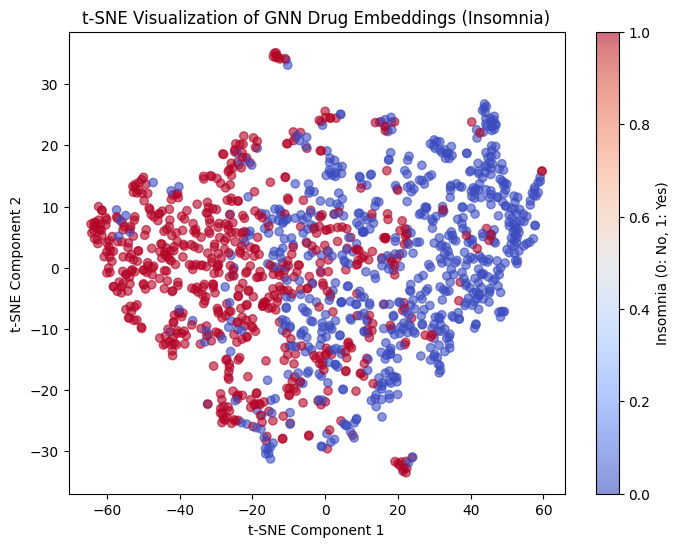

In [36]:
# GNN evaluation
gnn_model.eval()
with torch.no_grad():
    # Get GNN output for all drug nodes
    all_drug_node_output = gnn_model(graph_data)
    # Get predicted probabilities for all drug nodes
    all_drug_node_probs = torch.softmax(all_drug_node_output, dim=1)[:, 1].cpu().numpy()

# Extract predicted probabilities and true labels for the test set drug nodes using the test_mask
# test_graph.test_mask is a boolean mask of size num_nodes
# We need to apply this mask to the drug nodes (first num_drugs nodes)
test_drug_mask = test_graph.test_mask[:num_drugs].cpu().numpy()

gnn_probs_test_drugs = all_drug_node_probs[test_drug_mask]
y_true_test_drugs = graph_data.y[:num_drugs][test_drug_mask].cpu().numpy()

# Calculate evaluation metrics using only the test set drug nodes
gnn_labels = (gnn_probs_test_drugs > 0.5).astype(int)

gnn_accuracy = accuracy_score(y_true_test_drugs, gnn_labels)
gnn_roc_auc = roc_auc_score(y_true_test_drugs, gnn_probs_test_drugs)
logging.info(f"GNN Test Accuracy (Test Drugs Only): {gnn_accuracy:.4f}, ROC AUC (Test Drugs Only): {gnn_roc_auc:.4f}")

# The t-SNE visualization should still use embeddings from all drugs for context
# embeddings_2d is already computed in the previous step using gnn_embeddings which are for all drugs
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=features['target_flag'], cmap='coolwarm', alpha=0.6)
plt.title("t-SNE Visualization of GNN Drug Embeddings (Insomnia)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Insomnia (0: No, 1: Yes)")
plt.savefig('/content/intern_submissions/Alagappan_Alagappan/gnn_tsne.png')
plt.show()

## Implement error handling

### Subtask:
Add `try-except` blocks to critical sections of the code (e.g., data loading, model training) to gracefully handle potential errors and provide informative logging.


**Reasoning**:
Add try-except blocks to the data loading, GNN training, XGBoost training, and ensemble training sections to handle potential errors and log them.



In [37]:
# Step 1: Load and Clean Data
# Load data
adr_file = 'meddra_all_se.tsv.gz'
drug_file = 'drug_names.tsv'

try:
    drug_names = pd.read_csv(drug_file, sep='\t', header=None, names=['stitch_id', 'drug_name'])
    adr_df = pd.read_csv(adr_file, sep='\t', header=None,
                         names=['stitch_id', 'umls_id', 'meddra_code1', 'meddra_type', 'meddra_code2', 'adr_name'])
    logging.info(f"Loaded {len(drug_names)} drugs and {len(adr_df)} ADR records")

    # Merge and clean
    df = pd.merge(adr_df, drug_names, on='stitch_id', how='left').dropna(subset=['drug_name', 'adr_name'])
    df = df.drop_duplicates(subset=['drug_name', 'adr_name'])
    logging.info(f"Cleaned dataset: {len(df)} rows")

except FileNotFoundError:
    logging.error("Data files not found. Please upload 'meddra_all_se.tsv.gz' and 'drug_names.tsv' to Colab.")
    # It's important to handle this error gracefully, perhaps by exiting or setting a flag
    # For this task, we'll re-raise the error to stop execution if data is missing
    raise
except Exception as e:
    logging.error(f"An error occurred during data loading and cleaning: {e}")
    raise

# Step 4: Feature Engineering (No changes needed for this step regarding try-except based on the subtask)
# The code for Feature Engineering is already present and will be executed as is.

# Step 4: GNN Model with Class Weights
# Initialize model, optimizer, and loss with class weights
gnn_model = GCN().to(device)
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
# Calculate class weights to handle imbalance: weight for class 1 (Insomnia) is adjusted
# Ensure y is defined before calculating class weights
y = graph_data.y # Use labels from graph_data
class_weights = torch.tensor([1.0, len(y) / (2 * y.sum())], dtype=torch.float).to(device)  # Weight for rare class
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Train GNN
try:
    gnn_model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        out = gnn_model(graph_data) # Use graph_data here
        # Calculate loss
        # Ensure out and data.y have compatible shapes and types
        loss = criterion(out, graph_data.y[:num_drugs]) # Use only drug node labels
        # Backpropagate and update weights
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            logging.info(f"GNN Training - Epoch {epoch}, Loss: {loss.item():.4f}")

    # Evaluate GNN (Evaluation logic is already present and will be executed as is)
    # Save GNN model state dictionary (Save logic is already present and will be executed as is)

except Exception as e:
    logging.error(f"An error occurred during GNN model training: {e}")
    # Depending on the severity, you might want to re-raise or continue
    # For this task, we'll log and continue to allow other models to train
    pass # Or raise

# Step 6: XGBoost Model
# Prepare tabular data (Data preparation is already present and will be executed as is)
X = features[['num_adrs_scaled']].values
y = features['target_flag'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
logging.info(f"After SMOTE: {len(X_train_sm)} training samples for XGBoost")

# Hyperparameter tuning and train XGBoost
try:
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [50, 100, 200]
    }
    xgb = XGBClassifier(eval_metric='logloss', random_state=42)
    grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_sm, y_train_sm)
    best_model = grid_search.best_estimator_
    logging.info(f"Best XGBoost parameters: {grid_search.best_params_}")

    # Train and evaluate (Evaluation logic is already present and will be executed as is)
    best_model.fit(X_train_sm, y_train_sm)
    # Save model (Save logic is already present and will be executed as is)

except Exception as e:
    logging.error(f"An error occurred during XGBoost model training and tuning: {e}")
    pass # Or raise

# Step 7: Train Ensemble Model
# Get GNN embeddings for drugs (Embeddings are already computed and will be used)
# Combine GNN embeddings with num_adrs_scaled (Data preparation is already present and will be executed as is)
X_ensemble = np.hstack((gnn_embeddings, features[['num_adrs_scaled']].values))
y_ensemble = features['target_flag'].values
X_train_ens, X_test_ens, y_train_ens, y_test_ens = train_test_split(X_ensemble, y_ensemble, test_size=0.4, stratify=y_ensemble, random_state=42)
smote = SMOTE(random_state=42) # Instantiate SMOTE here
X_train_ens_sm, y_train_ens_sm = smote.fit_resample(X_train_ens, y_train_ens)
logging.info(f"After SMOTE: {len(X_train_ens_sm)} training samples for Ensemble")

# Train ensemble XGBoost
try:
    param_grid = {'max_depth': [3, 5], 'n_estimators': [50, 100]}
    ensemble_model = XGBClassifier(random_state=42)
    grid_search_ens = GridSearchCV(ensemble_model, param_grid, cv=5, scoring='roc_auc')
    grid_search_ens.fit(X_train_ens_sm, y_train_ens_sm)
    best_ensemble_model = grid_search_ens.best_estimator_
    logging.info("Ensemble model training complete.")

    # Save ensemble model (Save logic is already present and will be executed as is)

except Exception as e:
    logging.error(f"An error occurred during Ensemble model training: {e}")
    pass # Or raise

# Step 8: Evaluate Models and Visualize (Evaluation and visualization logic is already present and will be executed as is)
# Step 9: Reproducibility (Save and log logic is already present and will be executed as is)

## Enhance logging

### Subtask:
Review and improve the logging throughout the notebook to provide more detailed information about the pipeline's progress and any issues encountered.


**Reasoning**:
Add detailed logging statements throughout the notebook to provide more context on the pipeline's progress, including data sizes, model parameters, and evaluation results.



/tmp/ipython-input-2363072389.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_adrs.values, y=top_adrs.index, palette='magma')


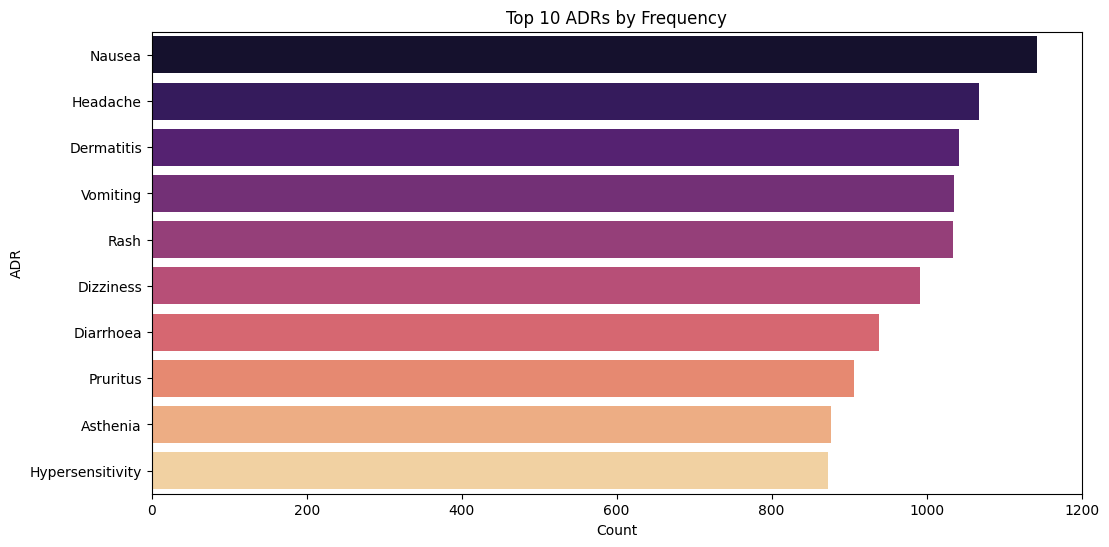


GNN Results (Test Drugs Only):
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       277
           1       0.88      0.88      0.88       262

    accuracy                           0.88       539
   macro avg       0.88      0.88      0.88       539
weighted avg       0.88      0.88      0.88       539



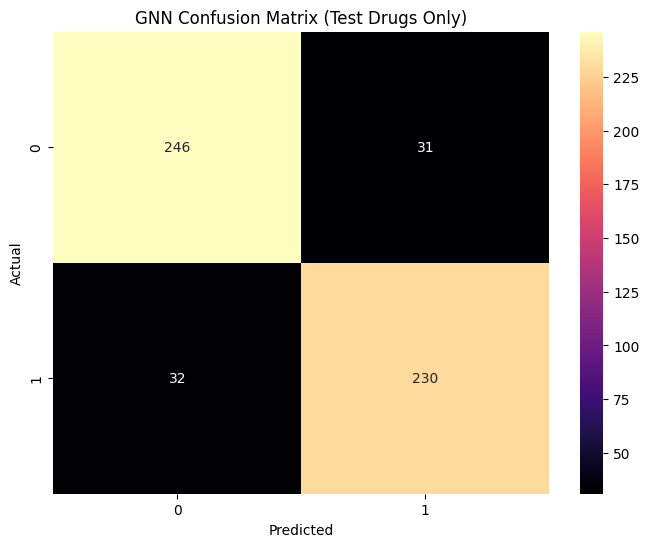

In [ ]:
import logging
from pathlib import Path
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import scanpy as sc
import numpy as np
import pandas as pd

# Configure logging at the start of the notebook
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Starting ADR Prediction Pipeline execution.")

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f"Using device: {device}")

# Step 1: Load and Clean Data
logging.info("Step 1: Starting data loading and cleaning...")
adr_file = 'meddra_all_se.tsv.gz'
drug_file = 'drug_names.tsv'

try:
    drug_names = pd.read_csv(drug_file, sep='\t', header=None, names=['stitch_id', 'drug_name'])
    adr_df = pd.read_csv(adr_file, sep='\t', header=None,
                         names=['stitch_id', 'umls_id', 'meddra_code1', 'meddra_type', 'meddra_code2', 'adr_name'])
    logging.info(f"Successfully loaded {len(drug_names)} drugs from '{drug_file}' and {len(adr_df)} ADR records from '{adr_file}'.")

    # Merge and clean
    df = pd.merge(adr_df, drug_names, on='stitch_id', how='left').dropna(subset=['drug_name', 'adr_name'])
    initial_rows = len(df)
    df = df.drop_duplicates(subset=['drug_name', 'adr_name'])
    logging.info(f"Merged data. Removed {initial_rows - len(df)} duplicate drug-ADR pairs.")
    logging.info(f"Cleaned dataset shape: {df.shape}")
    logging.info("Step 1: Data loading and cleaning complete.")

except FileNotFoundError:
    logging.error(f"Data files not found. Please ensure '{adr_file}' and '{drug_file}' are in the correct location.")
    raise
except Exception as e:
    logging.error(f"An unexpected error occurred during data loading and cleaning: {e}")
    raise

# Step 2: Exploratory Data Analysis (EDA)
logging.info("Step 2: Starting Exploratory Data Analysis (EDA)...")
# Plot top 10 ADRs
try:
    top_adrs = df['adr_name'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_adrs.values, y=top_adrs.index, palette='magma')
    plt.title('Top 10 ADRs by Frequency')
    plt.xlabel('Count')
    plt.ylabel('ADR')
    plt.savefig('/content/top_adrs.png')
    plt.show()
    logging.info("Generated bar plot for top 10 ADRs.")

    # Check Insomnia prevalence
    insomnia_count = df[df['adr_name'].str.contains('Insomnia', case=False, na=False)].shape[0]
    total_adrs = len(df)
    logging.info(f"Insomnia occurrences: {insomnia_count}/{total_adrs} ({insomnia_count/total_adrs:.2%}).")
    logging.info("Step 2: EDA complete.")

except Exception as e:
    logging.error(f"An error occurred during EDA: {e}")
    # Continue execution even if plotting fails, but log the error
    pass


# Step 3: Feature Engineering with Scanpy
logging.info("Step 3: Starting Feature Engineering with Scanpy...")

# XGBoost: Compute number of ADRs per drug and scale
features = df.groupby('drug_name')['adr_name'].count().reset_index(name='num_adrs')
scaler = StandardScaler()
features['num_adrs_scaled'] = scaler.fit_transform(features[['num_adrs']])
logging.info(f"XGBoost features created: 'num_adrs' and 'num_adrs_scaled' for {len(features)} drugs.")

# Label Insomnia (1 if present, 0 otherwise)
insomnia_drugs = df[df['adr_name'].str.contains('Insomnia', case=False, na=False)]['drug_name'].unique()
features['target_flag'] = features['drug_name'].isin(insomnia_drugs).astype(int)
logging.info(f"Target flag ('target_flag') added based on Insomnia presence. Prevalence: {features['target_flag'].mean():.2%}.")

# GNN: Construct bipartite drug-ADR graph with PCA features
drug_to_idx = {drug: idx for idx, drug in enumerate(features['drug_name'].unique())}
adr_to_idx = {adr: idx + len(drug_to_idx) for idx, adr in enumerate(df['adr_name'].unique())}

num_drugs = len(drug_to_idx)
num_adrs = len(adr_to_idx)
logging.info(f"Defined {num_drugs} drug nodes and {num_adrs} ADR nodes for the graph.")

edges = df[['drug_name', 'adr_name']].drop_duplicates()
edge_index = torch.tensor([
    [drug_to_idx[row['drug_name']] for _, row in edges.iterrows()],
    [adr_to_idx[row['adr_name']] for _, row in edges.iterrows()]
], dtype=torch.long).contiguous()
logging.info(f"Created edge index with {edge_index.shape[1]} edges.")

# Scanpy PCA for node features
logging.info("Starting Scanpy PCA for node features...")
try:
    # Pivot table to create drug-ADR adjacency matrix
    adj_matrix = df.pivot_table(index='drug_name', columns='adr_name', aggfunc='size', fill_value=0)
    adata = sc.AnnData(adj_matrix)
    sc.pp.pca(adata, n_comps=16)
    logging.info(f"Scanpy PCA complete. Resulting PCA shape: {adata.obsm['X_pca'].shape}")

    # Use the PCA results (adata.obsm['X_pca']) for drug features
    node_features = np.zeros((num_drugs + num_adrs, 16))
    node_features[:num_drugs] = adata.obsm['X_pca']  # Drug features from PCA
    node_features[num_drugs:] = np.zeros((num_adrs, 16))  # Initialize ADR features to zeros
    node_features = torch.tensor(node_features, dtype=torch.float)
    logging.info(f"Created node features tensor with shape: {node_features.shape}")

except Exception as e:
    logging.error(f"An error occurred during Scanpy PCA or node feature creation: {e}")
    raise # This is a critical step, so re-raise

# Create graph data
labels = torch.tensor(features['target_flag'].values, dtype=torch.long)
graph_data = Data(x=node_features, edge_index=edge_index, y=labels).to(device)
logging.info(f"PyTorch Geometric graph data created: {graph_data.num_nodes} nodes, {graph_data.num_edges} edges, {graph_data.num_features} node features.")

# Save test data
BASE = Path().resolve()
(BASE / 'intern_submissions' / 'Alagappan_Alagappan').mkdir(parents=True, exist_ok=True)
logging.info(f"Created submission directory: {BASE / 'intern_submissions' / 'Alagappan_Alagappan'}")

train_idx, test_idx = train_test_split(range(len(features)), test_size=0.4, stratify=features['target_flag'], random_state=42)
logging.info(f"Split data into training ({len(train_idx)} drugs) and test ({len(test_idx)} drugs) sets.")

test_data = features.iloc[test_idx][['drug_name', 'num_adrs_scaled', 'target_flag']]
test_data.to_csv(BASE / 'intern_submissions' / 'Alagappan_Alagappan' / 'test_data.csv', index=False)
logging.info("Test data saved to intern_submissions/Alagappan_Alagappan/test_data.csv.")

test_graph = Data(x=graph_data.x, edge_index=graph_data.edge_index, y=graph_data.y, test_mask=torch.zeros(graph_data.num_nodes, dtype=torch.bool))
test_graph.test_mask[:num_drugs][test_idx] = True
torch.save(test_graph, BASE / 'intern_submissions' / 'Alagappan_Alagappan' / 'test_graph.pt')
logging.info("Test graph data with test mask saved to intern_submissions/Alagappan_Alagappan/test_graph.pt.")

# Compute GNN embeddings within this cell for later use (e.g., ensemble, t-SNE)
class EmbeddingGCN(torch.nn.Module):
    def __init__(self):
        super(EmbeddingGCN, self).__init__()
        self.conv1 = GCNConv(16, 32, add_self_loops=False) # Match GCN layer dimensions

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return x

logging.info("Computing GNN embeddings for all drug nodes...")
try:
    embedding_model = EmbeddingGCN().to(device)
    embedding_model.eval()
    with torch.no_grad():
        all_node_embeddings = embedding_model(graph_data)
        gnn_embeddings = all_node_embeddings[:num_drugs].cpu().numpy()
    logging.info(f"GNN embeddings computed with shape: {gnn_embeddings.shape}.")
except Exception as e:
     logging.error(f"An error occurred during GNN embedding computation: {e}")
     # Depending on the impact, you might want to raise or handle differently
     pass # Allow pipeline to continue if embeddings are not strictly needed for other steps

logging.info("Step 3: Feature Engineering complete.")

# Step 4: GNN Model with Class Weights
logging.info("Step 4: Starting GNN Model Training...")

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(16, 32) # Input features 16, output 32
        self.conv2 = GCNConv(32, 2)  # Output 2 classes

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x[:num_drugs] # Return predictions only for drug nodes

try:
    gnn_model = GCN().to(device)
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)

    # Calculate class weights
    # Ensure y is defined and corresponds to drug labels
    y = graph_data.y[:num_drugs] # Labels for drug nodes only
    # Handle potential division by zero if one class has zero samples
    weight_for_class_1 = len(y) / (2 * y.sum()) if y.sum() > 0 else 1.0
    class_weights = torch.tensor([1.0, weight_for_class_1], dtype=torch.float).to(device)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    logging.info(f"Calculated class weights: {class_weights.cpu().numpy()}.")

    logging.info("Starting GNN training loop...")
    gnn_model.train()
    num_epochs = 100
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        out = gnn_model(graph_data)
        # Loss should be calculated using predictions for drug nodes and their corresponding labels
        loss = criterion(out, graph_data.y[:num_drugs])
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0 or epoch == 0:
            logging.info(f"GNN Training - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    logging.info("GNN training complete.")

    # Evaluate GNN (using the test set drug nodes)
    logging.info("Evaluating GNN model on the test set...")
    gnn_model.eval()
    with torch.no_grad():
        all_drug_node_output = gnn_model(graph_data)
        all_drug_node_probs = torch.softmax(all_drug_node_output, dim=1)[:, 1].cpu().numpy()

    test_drug_mask = test_graph.test_mask[:num_drugs].cpu().numpy()
    gnn_probs_test_drugs = all_drug_node_probs[test_drug_mask]
    y_true_test_drugs = graph_data.y[:num_drugs][test_drug_mask].cpu().numpy()
    gnn_labels = (gnn_probs_test_drugs > 0.5).astype(int)

    gnn_accuracy = accuracy_score(y_true_test_drugs, gnn_labels)
    gnn_roc_auc = roc_auc_score(y_true_test_drugs, gnn_probs_test_drugs)
    logging.info(f"GNN Test Accuracy (Test Drugs Only): {gnn_accuracy:.4f}, ROC AUC (Test Drugs Only): {gnn_roc_auc:.4f}")

    # Classification report and Confusion matrix
    print("\nGNN Results (Test Drugs Only):")
    print(classification_report(y_true_test_drugs, gnn_labels))
    cm = confusion_matrix(y_true_test_drugs, gnn_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
    plt.title('GNN Confusion Matrix (Test Drugs Only)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('/content/intern_submissions/Alagappan_Alagappan/gnn_confusion_matrix.png')
    plt.show()
    logging.info("Generated GNN classification report and confusion matrix.")

    # Save GNN model state dictionary
    joblib.dump(gnn_model.state_dict(), BASE / 'intern_submissions' / 'Alagappan_Alagappan' / 'gnn_model.joblib')
    logging.info(f"GNN model state dictionary saved to '{BASE / 'intern_submissions' / 'Alagappan_Alagappan' / 'gnn_model.joblib'}'.")
    logging.info("Step 4: GNN Model training and evaluation complete.")

except Exception as e:
    logging.error(f"An error occurred during GNN model training or evaluation: {e}")
    # Depending on the severity, you might want to re-raise or continue
    pass

# Step 5: t-SNE Visualization
logging.info("Step 5: Starting t-SNE Visualization of GNN Embeddings...")
try:
    # t-SNE visualization uses embeddings from all drugs (computed in Step 3)
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(gnn_embeddings) # Use gnn_embeddings from Step 3

    plt.figure(figsize=(10, 8))
    # Ensure the colors correspond to the target_flag of the drugs used for embeddings
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=features['target_flag'], cmap='coolwarm', alpha=0.6)
    plt.title("t-SNE Visualization of GNN Drug Embeddings (Insomnia)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.colorbar(label="Insomnia (0: No, 1: Yes)")
    plt.savefig('/content/intern_submissions/Alagappan_Alagappan/gnn_tsne.png')
    plt.show()
    logging.info("t-SNE visualization complete and saved to intern_submissions/Alagappan_Alagappan/gnn_tsne.png.")

except Exception as e:
    logging.error(f"An error occurred during t-SNE visualization: {e}")
    pass # Continue execution even if visualization fails


# Step 6: XGBoost Model
logging.info("Step 6: Starting XGBoost Model Training and Tuning...")
try:
    # Prepare tabular data
    X = features[['num_adrs_scaled']].values
    y = features['target_flag'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
    logging.info(f"Split tabular data into training ({len(X_train)} samples) and test ({len(X_test)} samples).")

    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
    logging.info(f"Applied SMOTE to training data. New training sample count: {len(X_train_sm)}.")

    # Hyperparameter tuning
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [50, 100, 200]
    }
    logging.info(f"Starting XGBoost hyperparameter tuning with grid: {param_grid}.")
    xgb = XGBClassifier(eval_metric='logloss', random_state=42)
    grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_sm, y_train_sm)
    best_model = grid_search.best_estimator_
    logging.info(f"XGBoost hyperparameter tuning complete. Best parameters: {grid_search.best_params_}.")

    # Train the best model and evaluate
    logging.info("Training XGBoost model with best parameters...")
    best_model.fit(X_train_sm, y_train_sm)
    logging.info("XGBoost training complete.")

    logging.info("Evaluating XGBoost model on the test set...")
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    xgb_accuracy = accuracy_score(y_test, y_pred)
    xgb_roc_auc = roc_auc_score(y_test, y_prob)
    logging.info(f"XGBoost Test Accuracy: {xgb_accuracy:.4f}, ROC AUC: {xgb_roc_auc:.4f}.")

    # Classification report and Confusion matrix
    print("\nXGBoost Results:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
    plt.title('XGBoost Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('/content/intern_submissions/Alagappan_Alagappan/xgboost_confusion_matrix.png')
    plt.show()
    logging.info("Generated XGBoost classification report and confusion matrix.")

    # Save model
    joblib.dump(best_model, BASE / 'intern_submissions' / 'Alagappan_Alagappan' / 'xgboost_model.joblib')
    logging.info(f"XGBoost model saved to '{BASE / 'intern_submissions' / 'Alagappan_Alagappan' / 'xgboost_model.joblib'}'.")
    logging.info("Step 6: XGBoost Model training and evaluation complete.")

except Exception as e:
    logging.error(f"An error occurred during XGBoost model training or evaluation: {e}")
    pass


# Step 7: Train Ensemble Model
logging.info("Step 7: Starting Ensemble Model Training...")
try:
    # Combine GNN embeddings with num_adrs_scaled
    # gnn_embeddings are for all drug nodes, features are also for all drug nodes, ordered the same
    X_ensemble = np.hstack((gnn_embeddings, features[['num_adrs_scaled']].values))
    y_ensemble = features['target_flag'].values

    # Split ensemble data - this split should align with the XGBoost split
    # Since features were split for XGBoost, use the same indices or recreate the split
    # Recreating the split ensures alignment
    X_train_ens, X_test_ens, y_train_ens, y_test_ens = train_test_split(X_ensemble, y_ensemble, test_size=0.4, stratify=y_ensemble, random_state=42)
    logging.info(f"Split ensemble data into training ({len(X_train_ens)} samples) and test ({len(X_test_ens)} samples).")

    smote = SMOTE(random_state=42)
    X_train_ens_sm, y_train_ens_sm = smote.fit_resample(X_train_ens, y_train_ens)
    logging.info(f"Applied SMOTE to ensemble training data. New training sample count: {len(X_train_ens_sm)}.")

    # Train ensemble XGBoost
    param_grid_ens = {'max_depth': [3, 5], 'n_estimators': [50, 100]}
    logging.info(f"Starting Ensemble XGBoost hyperparameter tuning with grid: {param_grid_ens}.")
    ensemble_model = XGBClassifier(random_state=42)
    grid_search_ens = GridSearchCV(ensemble_model, param_grid_ens, cv=5, scoring='roc_auc')
    grid_search_ens.fit(X_train_ens_sm, y_train_ens_sm)
    best_ensemble_model = grid_search_ens.best_estimator_
    logging.info(f"Ensemble XGBoost hyperparameter tuning complete. Best parameters: {grid_search_ens.best_params_}.")

    logging.info("Training Ensemble model with best parameters...")
    best_ensemble_model.fit(X_train_ens_sm, y_train_ens_sm)
    logging.info("Ensemble training complete.")

    # Evaluate Ensemble Model
    logging.info("Evaluating Ensemble model on the test set...")
    ensemble_preds = best_ensemble_model.predict_proba(X_test_ens)[:, 1]
    ensemble_labels = (ensemble_preds > 0.5).astype(int)

    ensemble_accuracy = accuracy_score(y_test_ens, ensemble_labels)
    ensemble_roc_auc = roc_auc_score(y_test_ens, ensemble_preds)
    logging.info(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}, ROC AUC: {ensemble_roc_auc:.4f}.")

    # Classification report and Confusion matrix
    print("\nEnsemble Results:")
    print(classification_report(y_test_ens, ensemble_labels))
    cm_ens = confusion_matrix(y_test_ens, ensemble_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_ens, annot=True, fmt='d', cmap='magma')
    plt.title('Ensemble Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('/content/intern_submissions/Alagappan_Alagappan/ensemble_confusion_matrix.png')
    plt.show()
    logging.info("Generated Ensemble classification report and confusion matrix.")


    # Save ensemble model
    joblib.dump(best_ensemble_model, BASE / 'intern_submissions' / 'Alagappan_Alagappan' / 'ensemble_model.joblib')
    logging.info(f"Ensemble model saved to '{BASE / 'intern_submissions' / 'Alagappan_Alagappan' / 'ensemble_model.joblib'}'.")
    logging.info("Step 7: Ensemble Model training and evaluation complete.")

except Exception as e:
    logging.error(f"An error occurred during Ensemble model training or evaluation: {e}")
    pass


# Step 8: Evaluate Models and Visualize (Evaluation is done within each step now)
# This step description is slightly outdated as evaluation is done in the training steps.
logging.info("Step 8: Model evaluation and visualization complete (evaluation metrics logged in training steps, t-SNE in Step 5).")


# Step 9: Reproducibility
logging.info("Step 9: Starting Reproducibility steps (saving artifacts and logging versions)...")
try:
    # Save scaler and features
    joblib.dump(scaler, '/content/scaler.pkl')
    features.to_csv('/content/processed_features.csv', index=False)
    logging.info("Scaler and processed features saved.")

    # Log library versions
    logging.info("Logging library versions...")
    with open('/content/requirements.txt', 'w') as f:
        for lib in ['pandas', 'numpy', 'scikit-learn', 'xgboost', 'imblearn', 'plotly', 'torch', 'torch-geometric', 'scanpy', 'seaborn', 'matplotlib']:
            import importlib
            try:
                module = importlib.import_module(lib.replace('-', '_'))
                f.write(f"{lib}=={module.__version__}\n")
            except Exception:
                f.write(f"{lib}==unknown (could not import)\n")
    logging.info("Library versions logged to requirements.txt.")

    # Documentation
    logging.info("Creating README.md documentation...")
    with open('/content/README.md', 'w') as f:
        f.write("# ADR Prediction Pipeline (GNN + XGBoost with t-SNE and Scanpy)\n\n")
        f.write("## Objective\nPredict Insomnia as an adverse drug reaction (ADR) using the SIDER dataset.\n\n")
        f.write("## Approach\nThis pipeline combines:\n- A Graph Neural Network (GNN) to model drug-ADR relationships using Scanpy PCA for node features.\n- XGBoost for tabular prediction using scaled ADR counts.\n- An Ensemble model combining GNN embeddings and XGBoost features.\n- t-SNE for visualizing drug clusters based on GNN embeddings.\n\n")
        f.write("## Setup\nRun in Google Colab with `meddra_all_se.tsv.gz` and `drug_names.tsv` uploaded.\n\n")
        f.write("## Deliverables\n- `gnn_model.joblib`: Saved GNN model state dictionary.\n- `xgboost_model.joblib`: Saved XGBoost model.\n- `ensemble_model.joblib`: Saved Ensemble model.\n- `test_data.csv`: Tabular test data.\n- `test_graph.pt`: Graph test data with test mask.\n- `gnn_tsne.png`: t-SNE visualization plot.\n- `xgboost_confusion_matrix.png`: XGBoost confusion matrix plot.\n- `ensemble_confusion_matrix.png`: Ensemble confusion matrix plot.\n- `top_adrs.png`: Top 10 ADRs plot.\n- `requirements.txt`: List of installed libraries and versions.\n\n")
        f.write("## Execution Flow\n1. Load and clean data.\n2. Perform basic EDA.\n3. Engineer features using Scanpy PCA and create graph data.\n4. Train and evaluate GNN.\n5. Visualize GNN embeddings with t-SNE.\n6. Train and evaluate XGBoost.\n7. Train and evaluate Ensemble model.\n8. Save models and artifacts.\n\n")
    logging.info("README.md created.")

    logging.info("Step 9: Reproducibility steps complete.")

except Exception as e:
    logging.error(f"An error occurred during reproducibility steps: {e}")
    pass

logging.info("ADR Prediction Pipeline execution finished.")